# Calculate CAPPI Coverage

## Aim
1. Generate a map showing the area covered at a specific CAPPI level with a contour line based on elevation

## Objective
1. Get the maximum distance of radar coverage for each CAPPI height
2. Generate arrays for lat,lon at each radial and bin within range
3. Generate array for elevation at each radial and bin within range
4. Generate array with lat,lon where elevation is above CAPPI or maximum range if not
5. Contour from array

## Requirements
1. Maximum distance for given CAPPI
    - Find the Distance where beam heigh of lowest beam is equal to CAPPI height
    - Calculate beam height at different distance intervals from the radar until equal to CAPPI
2. Use wradlib
3. use wradlib
4. Simple loop

## Maximum distance for each CAPPI

In [25]:
amsl = 0
threshold_height = 3.5 # Threshold height in kilometers
cappi = threshold_height*1000

In [26]:
import math

# Earth's radius in km
R = 6374
# Modified Earth's radius accounting for curvature effect
Ri = 4/3 * R

def max_distance(deg, threshold_height, source_altitude):
    # Convert the angle from degrees to radians
    tha = math.radians(deg)
    
    # Coefficients of the quadratic equation
    A = 1
    B = 2 * Ri * math.sin(tha)
    C = Ri**2 - (threshold_height - source_altitude / 1000 + Ri)**2
    
    # Discriminant
    discriminant = B**2 - 4 * A * C
    
    if discriminant < 0:
        return None  # No real solution, the threshold cannot be reached
    
    # Calculate the two possible solutions
    r1 = (-B + math.sqrt(discriminant)) / (2 * A)
    r2 = (-B - math.sqrt(discriminant)) / (2 * A)
    
    # We are interested in the positive distance
    if r1 >= 0 and r2 >= 0:
        return max(r1, r2)
    elif r1 >= 0:
        return r1
    elif r2 >= 0:
        return r2
    else:
        return None  # No positive solution

# Example usage
deg = 0.5  # Elevation angle in degrees
source_altitude = amsl  # Source altitude in meters

max_dist = max_distance(deg, threshold_height, source_altitude)
print(f"The maximum distance before the beam height exceeds {threshold_height} km is: {max_dist} km")

The maximum distance before the beam height exceeds 3.5 km is: 180.7933411521797 km


# Lat, Lon Arrays

In [27]:
import wradlib as wrl
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()
import numpy as np

In [28]:
sitecoords = (28.21,-25.91, 1560) #(28.21,-25.91, 1560)
nrays = 360  # number of rays
el = 0.5  # vertical antenna pointing angle (deg)
range_res = 250.0 # range resolution (meters)
nbins = int(max_dist)*1000/range_res  # number of range bins
nbins = int(nbins)

In [29]:
coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
coords = wrl.georef.spherical_to_proj(
    coord[..., 0], coord[..., 1], coord[..., 2], sitecoords
)
lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]

In [30]:
polcoords = coords[..., :2]
print("lon,lat", polcoords.shape)

lon,lat (360, 720, 2)


# Elevation Array

In [31]:
rlimits = (lon.min(), lat.min(), lon.max(), lat.max())
print(
    "Radar bounding box:\n\t%.2f\n%.2f             %.2f\n\t%.2f"
    % (lat.max(), lon.min(), lon.max(), lat.min())
)

Radar bounding box:
	-24.29
26.42             30.00
	-27.53


In [32]:
ds = wrl.io.open_raster('../Data/GIS/gt30e020s10.tif') #gt30e020s10.tif
rastervalues, rastercoords, crs = wrl.georef.extract_raster_dataset(ds, nodata=-32768)

In [33]:
# Clip the region inside our bounding box
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[1] : ind[3], ind[0] : ind[2], ...]
rastervalues = rastervalues[ind[1] : ind[3], ind[0] : ind[2]]

# Map rastervalues to polar grid points
polarvalues = wrl.ipol.cart_to_irregular_spline(
    rastercoords, rastervalues, polcoords, prefilter=False)

In [34]:
polarvalues

array([[1513, 1512, 1510, ..., 1256, 1243, 1234],
       [1513, 1512, 1510, ..., 1263, 1271, 1279],
       [1513, 1512, 1510, ..., 1354, 1359, 1360],
       ...,
       [1513, 1512, 1510, ..., 1194, 1201, 1206],
       [1513, 1512, 1510, ..., 1255, 1253, 1250],
       [1513, 1512, 1510, ..., 1237, 1233, 1229]], dtype=int16)

# Above CAPPI Array

In [35]:
#cappi = 1000

In [36]:
import numpy as np

coverage_points = []

elevation = np.atleast_1d(polarvalues)
lon_lat = np.atleast_1d(polcoords)

for angle_idx in range(elevation.shape[0]):
    point_found = False  # To check if a valid point has been found in the current radial
    for range_idx in range(elevation.shape[1]):
        if elevation[angle_idx, range_idx] >= cappi:
            coverage_points.append(lon_lat[angle_idx, range_idx])
            point_found = True
            break
    if not point_found:
        # Append the last point in the current radial if no point meets the condition
        coverage_points.append(lon_lat[angle_idx, -1])

In [37]:
coverage_points = np.array(coverage_points)

# Countour

In [38]:
from shapely.geometry import Polygon, Point, LineString
import geopandas as gpd
import pandas as pd

df = pd.DataFrame(coverage_points, columns=['longitude', 'latitude'])
# Create a geometry column from the latitude and longitude columns
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

In [39]:
# Convert the GeoDataFrame back to separate arrays for creating LineStrings
longitudes = gdf['longitude'].values
latitudes = gdf['latitude'].values

# Create a single LineString connecting all points
points = [(longitudes[i], latitudes[i]) for i in range(len(longitudes))]
line = LineString(points)

# Create a GeoDataFrame with the LineString
lines_gdf = gpd.GeoDataFrame(geometry=[line])

<Axes: >

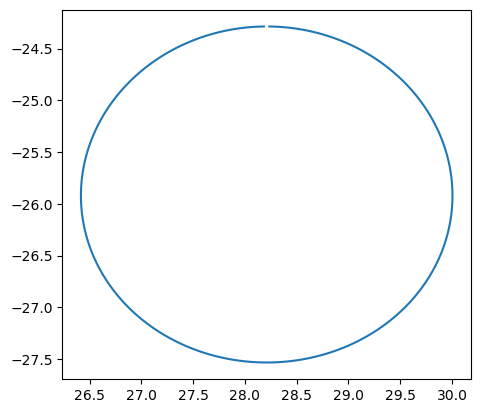

In [40]:
lines_gdf.plot()

In [41]:
lines_gdf.to_file(f'coverageline_{threshold_height}.shp')

# Create Plot

In [9]:
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

In [3]:
dem = xr.open_dataset('../Data/GIS/gt30e020s10.tif')

In [4]:
radar = gpd.read_file('../Data/GIS/Data/Irene_Radar.shp')
aoi = gpd.read_file('../Data/GIS/Data/Provinces.shp')

In [5]:
files = glob.glob('../Data/CoverageData/*.shp')

In [6]:
combined_cappi = gpd.GeoDataFrame()
for file in files:
    name = os.path.basename(file).split('_')[-1].replace('.shp', '')
    dftmp = gpd.read_file(file)
    dftmp['CAPPI'] = name
    if len(combined_cappi) ==0:
        combined_cappi = dftmp
    else:
        combined_cappi = pd.concat([combined_cappi, dftmp], axis=0)

In [7]:
dem = dem.rename({'band_data':'Elevation (m)'})

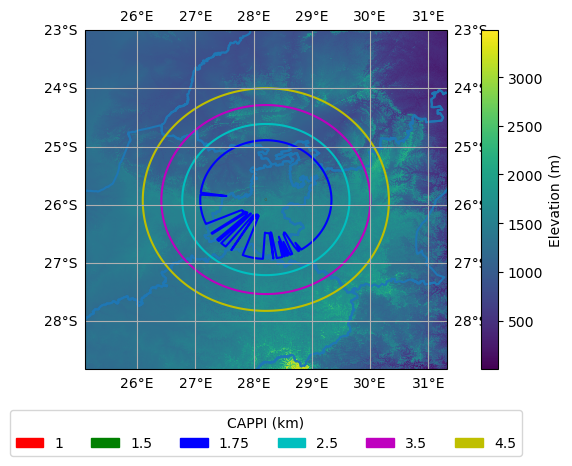

In [28]:
# Define your color map and labels
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
cappi_levels = sorted(combined_cappi['CAPPI'].unique())
color_map = {level: colors[i % len(colors)] for i, level in enumerate(cappi_levels)}

bound = combined_cappi.unary_union.bounds

ax = plt.subplot(projection=ccrs.PlateCarree())

dem['Elevation (m)'][0].plot.pcolormesh(ax=ax)

aoi.boundary.plot(ax=ax)

# Plot each CAPPI level with a different color
for level, geom in combined_cappi.groupby('CAPPI'):
    geom.plot(ax=ax, color=color_map[level], label=f'CAPPI {level}')

ax.gridlines(draw_labels=["top", "bottom", "left", "right"])

plt.xlim(bound[0]-1, bound[2]+1)
plt.ylim(bound[1]-1, bound[3]+1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('')

# Add a legend
legend_handles = [mpatches.Patch(color=color_map[level], label=f'{level}') for level in cappi_levels]
ax.legend(handles=legend_handles, title='CAPPI (km)',loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(cappi_levels))

plt.tight_layout(rect=[0, 0, 1.2, 1])  # Adjust right margin to make space for colorbar

# # Add colorbar
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=dem['Elevation (m)'][0].min(), vmax=dem['Elevation (m)'][0].max()))
# cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, aspect=50)
# cbar.set_label('Elevation (m)')

plt.savefig('CAPPI_Coverage.png', dpi=400)

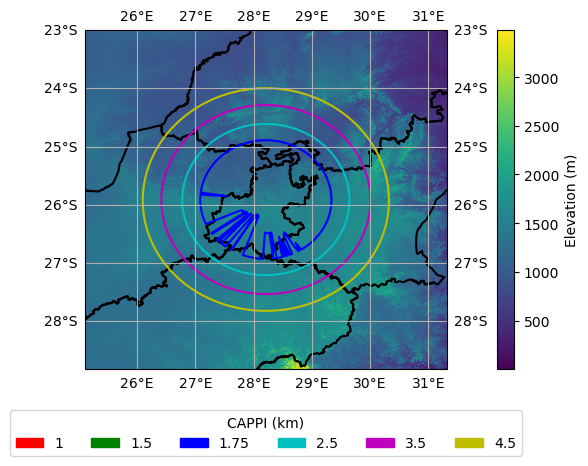

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import xarray as xr

# Define your color map and labels
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
cappi_levels = sorted(combined_cappi['CAPPI'].unique())
color_map = {level: colors[i % len(colors)] for i, level in enumerate(cappi_levels)}

bound = combined_cappi.unary_union.bounds

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the DEM without automatic colorbar
dem_plot = dem['Elevation (m)'][0].plot.pcolormesh(ax=ax, add_colorbar=False)

# Plot the AOI boundary
aoi.boundary.plot(ax=ax, color='black')

# Plot each CAPPI level with a different color
for level, geom in combined_cappi.groupby('CAPPI'):
    geom.plot(ax=ax, color=color_map[level], label=f'CAPPI {level}')

# Add gridlines with labels
ax.gridlines(draw_labels=True)

# Set axis limits
plt.xlim(bound[0]-1, bound[2]+1)
plt.ylim(bound[1]-1, bound[3]+1)

# Set axis labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('')

# Add a legend
legend_handles = [mpatches.Patch(color=color_map[level], label=f'{level}') for level in cappi_levels]
ax.legend(handles=legend_handles, title='CAPPI (km)', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(cappi_levels))

# Adjust layout and add padding
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust right margin to make space for colorbar

# Add custom colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=dem['Elevation (m)'][0].min(), vmax=dem['Elevation (m)'][0].max()))
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.1)
cbar.set_label('Elevation (m)')

# Save the figure
plt.savefig('CAPPI_Coverage.png', dpi=400)

plt.show()